In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:

def preprocess_text_for_sentiment(text):
    """
    Limpia y preprocesa a lower, removes URLs, @mentions, #hashtags, and non-alphabetic characters.
    Does NOT handle stop words or lemmatization as those will be done separately.
    """
    text = text.lower() # Convertir a minúsculas
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Eliminar URLs
    text = re.sub(r'@\w+', '', text) # Eliminar menciones
    text = re.sub(r'#\w+', '', text) # Eliminar hashtags
    text = re.sub(r'[^a-z\s]', '', text) # Eliminar caracteres no alfabéticos

    # Stop word removal and lemmatization will be handled outside this function

    return text # Return cleaned text without stop words or lemmatization

def build_sentiment_model(vocab_size, embedding_dim, max_sequence_length, num_classes):
    """
    Construye un modelo RNN (LSTM) para clasificación de sentimiento.
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
        LSTM(128, dropout=0.2, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # 3 clases: positivo, negativo, neutral
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_sentiment_model(model, texts, sentiments, epochs=10, batch_size=32):
    """
    Entrena el modelo de sentimiento.
    texts: Lista de textos preprocesados.
    sentiments: Lista de etiquetas de sentimiento (ej. [0, 1, 2] para neg, neu, pos).
    """
    # Tokenización y padding
    tokenizer = Tokenizer(num_words=len(set(texts)), oov_token="<unk>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=model.input_shape[1])

    # Convertir sentimientos a one-hot encoding
    num_classes = model.output_shape[1]
    sentiment_labels = tf.keras.utils.to_categorical(sentiments, num_classes=num_classes)

    model.fit(padded_sequences, sentiment_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return model, tokenizer

def predict_sentiment(model, tokenizer, text, max_sequence_length):
    """
    Predice el sentimiento de un texto dado.
    """
    processed_text = preprocess_text_for_sentiment(text)
    # Apply stop word removal and lemmatization after basic preprocessing
    tokens = processed_text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_text_nltk = ' '.join(tokens)


    sequence = tokenizer.texts_to_sequences([processed_text_nltk])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

    prediction = model.predict(padded_sequence)[0]
    # Asumiendo que las clases son 0: negativo, 1: neutral, 2: positivo
    sentiment_map = {0: 'negativo', 1: 'neutral', 2: 'positivo'}
    predicted_class = np.argmax(prediction)
    return sentiment_map[predicted_class], prediction

In [ ]:
!unzip TwitterSentimentDataset-master.zip

Archive:  TwitterSentimentDataset-master.zip
a3a44a839397773484c8c6e0975fc47f9d2b961c
   creating: TwitterSentimentDataset-master/
  inflating: TwitterSentimentDataset-master/LICENSE  
  inflating: TwitterSentimentDataset-master/README.md  
  inflating: TwitterSentimentDataset-master/tweets_clean.txt  
  inflating: TwitterSentimentDataset-master/tweets_neg_clean.txt  
  inflating: TwitterSentimentDataset-master/tweets_pos_clean.txt  


In [ ]:
# Load the data from the extracted files
def load_tweets(filepath, label):
    """Loads tweets from a file and assigns a label."""
    tweets = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            tweets.append((line.strip(), label))
    return tweets

# Load positive, negative, and neutral tweets
positive_tweets = load_tweets('TwitterSentimentDataset-master/tweets_pos_clean.txt', 2) # 2 for positive
negative_tweets = load_tweets('TwitterSentimentDataset-master/tweets_neg_clean.txt', 0) # 0 for negative
neutral_tweets = load_tweets('TwitterSentimentDataset-master/tweets_clean.txt', 1)  # 1 for neutral

# Combine all tweets
all_tweets = positive_tweets + negative_tweets + neutral_tweets

# Separate texts and labels
texts = [tweet[0] for tweet in all_tweets]
labels = [tweet[1] for tweet in all_tweets]

print(f"Loaded {len(positive_tweets)} positive tweets.")
print(f"Loaded {len(negative_tweets)} negative tweets.")
print(f"Loaded {len(neutral_tweets)} neutral tweets.")
print(f"Total tweets loaded: {len(all_tweets)}")

Loaded 55360 positive tweets.
Loaded 122216 negative tweets.
Loaded 70734 neutral tweets.
Total tweets loaded: 248310


In [ ]:
# Prepare data for training: Tokenization and Padding
# Use the Tokenizer and pad_sequences from the first cell's imports

# Determine vocabulary size from the processed texts
# A reasonable approach is to use a large number or the actual vocabulary size if not too large
# Here we use a fixed number as defined in the build_sentiment_model example, but this could be dynamic
vocab_size = 10000 # Should match the vocab_size used in build_sentiment_model

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")
tokenizer.fit_on_texts(processed_texts)
sequences = tokenizer.texts_to_sequences(processed_texts)

# Determine max sequence length
# Use the max_sequence_length defined in the build_sentiment_model example
max_sequence_length = 100 # Should match the max_sequence_length used in build_sentiment_model

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Convert labels to numpy array
labels = np.array(labels)

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Max sequence length: {max_sequence_length}")
print(f"Shape of padded sequences: {padded_sequences.shape}")
print(f"Shape of labels: {labels.shape}")

Vocabulary size: 110510
Max sequence length: 100
Shape of padded sequences: (248310, 100)
Shape of labels: (248310,)


In [ ]:
import nltk
import os

# Set NLTK data path to a directory within the Colab environment
nltk_data_path = '/usr/local/share/nltk_data'
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
nltk.data.path.append(nltk_data_path)

# Download NLTK resources if not already present
try:
    nltk.data.find('corpora/stopwords.zip')
except nltk.downloader.DownloadError:
    nltk.download('stopwords', download_dir=nltk_data_path)
try:
    nltk.data.find('corpora/wordnet.zip')
except nltk.downloader.DownloadError:
    nltk.download('wordnet', download_dir=nltk_data_path)

print("NLTK resources checked/downloaded.")

NLTK resources checked/downloaded.


In [ ]:
from sklearn.utils import shuffle

# Shuffle the padded sequences and labels together
padded_sequences_shuffled, labels_shuffled = shuffle(padded_sequences, labels, random_state=42) # Using a random state for reproducibility

print("Data shuffled successfully.")

# Now, use the shuffled data for training
# The training cell will need to be re-run after this.

Data shuffled successfully.


In [ ]:
# Continue preprocessing with stop word removal and lemmatization
# Assuming 'texts' is loaded from a previous cell and 'stop_words' and 'lemmatizer' are initialized

processed_texts = []
for text in texts:
    # Apply basic preprocessing first
    cleaned_text = preprocess_text_for_sentiment(text)

    # Then apply NLTK-dependent steps
    tokens = cleaned_text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_texts.append(' '.join(tokens))

print("NLTK-dependent preprocessing complete.")
# Display a few examples of fully preprocessed text
print("\nExamples of fully preprocessed text:")
for i in range(5):
    print(f"Original: {texts[i]}")
    print(f"Processed: {processed_texts[i]}")

NLTK-dependent preprocessing complete.

Examples of fully preprocessed text:
Original: Se imaginan a los chicos agradeciendo por el premio con cara de orgullo?.Que bonito :).#MTVHottest One Direction
Processed: se imaginan los chico agradeciendo por el premio con cara de orgulloque bonito one direction
Original: Eclesiastes4:9-12 ♡ Siempre, promesa :)  https://t.co/XbrYsqa43T
Processed: eclesiastes siempre promesa
Original: @pedroj_ramirez Qué saborío, PJ. ya no compartes ni un gintonic con nosotros. :)
Processed: qu saboro pj ya compartes ni un gintonic con nosotros
Original: Buenos dias para todos. Feliz inicio de semana. :-) http://t.co/svMgEcaxLr
Processed: buenos dia para todos feliz inicio de semana
Original: @pepedom @bquintero Gracias! No es así, deja claro que es el 100% de aquí http://t.co/cD3VFu7hnH }:)
Processed: gracias e deja claro que e el de aqu


In [ ]:
# Train the sentiment model
# Use the build_sentiment_model function from the first cell to get the model instance
# Ensure the parameters match what was used to build the model initially
vocab_size = 10000
embedding_dim = 100
max_sequence_length = 100
num_classes = 3

# Rebuild the model if it was not kept in the environment or just use the existing one if available
# Assuming the model 'sentiment_model' from the first cell is available
if 'sentiment_model' not in locals():
    print("Building a new model as 'sentiment_model' was not found.")
    sentiment_model = build_sentiment_model(vocab_size, embedding_dim, max_sequence_length, num_classes)
    sentiment_model.summary()
else:
    print("Using the existing 'sentiment_model'.")

# Convert shuffled labels to one-hot encoding
sentiment_labels_one_hot_shuffled = tf.keras.utils.to_categorical(labels_shuffled, num_classes=num_classes)

print("Starting model training with shuffled data...")
# Train the model using shuffled data
history = sentiment_model.fit(padded_sequences_shuffled, sentiment_labels_one_hot_shuffled, epochs=3, batch_size=32, validation_split=0.2)

print("\nModel training complete.")
# You can access training history for evaluation if needed
# print(history.history)

Using the existing 'sentiment_model'.
Starting model training with shuffled data...
Epoch 1/3
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 1584s 255ms/step - accuracy: 0.4922 - loss: 1.0411 - val_accuracy: 0.4913 - val_loss: 1.0419
Epoch 2/3
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 1646s 256ms/step - accuracy: 0.4909 - loss: 1.0421 - val_accuracy: 0.4913 - val_loss: 1.0419
Epoch 3/3
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 1621s 252ms/step - accuracy: 0.4928 - loss: 1.0410 - val_accuracy: 0.4913 - val_loss: 1.0419

Model training complete.


In [ ]:
# Save the trained model
model_save_path = 'sentiment_model.keras' # Added .keras extension
sentiment_model.save(model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to sentiment_model.keras


In [ ]:
import nltk
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources using the default behavior
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print("NLTK resources downloaded and initialized.")

NLTK resources downloaded and initialized.


1552/1552 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step


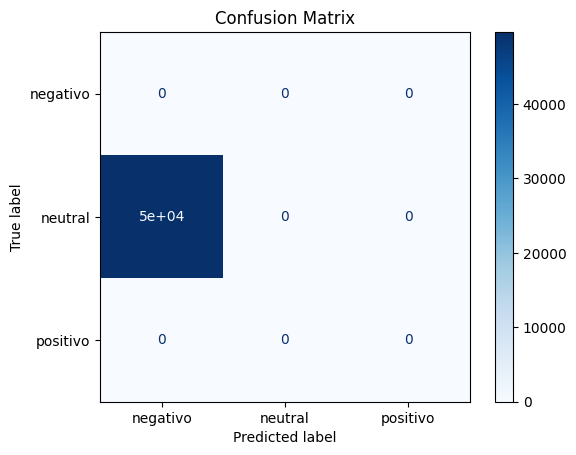

Confusion Matrix:
[[    0     0     0]
 [49662     0     0]
 [    0     0     0]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming you used validation_split=0.2 during training,
# the last 20% of your padded_sequences and sentiment_labels_one_hot were used for validation.
# We need to get the corresponding original labels for this validation set.

# Determine the size of the validation set
validation_size = int(len(padded_sequences) * 0.2)

# Get the validation data and labels
x_val = padded_sequences[-validation_size:]
y_val_one_hot = sentiment_labels_one_hot[-validation_size:]

# Get the true labels for the validation set (from the original 'labels' array)
y_true = labels[-validation_size:]

# Make predictions on the validation set
y_pred_probs = sentiment_model.predict(x_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Define class labels (make sure these match your label encoding: 0:neg, 1:neu, 2:pos)
class_names = ['negativo', 'neutral', 'positivo']

# Generate the confusion matrix, explicitly defining the labels to ensure a 3x3 matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))


# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:")
print(cm)

In [ ]:
# Display a few examples of original tweets and their assigned numerical labels
print("Examples of original tweets and their assigned labels:")
for i in range(10): # Display the first 10 examples
    print(f"Tweet: {all_tweets[i][0]}")
    print(f"Label: {all_tweets[i][1]}")
    print("-" * 20)

# Also, check the distribution of labels in the full dataset
from collections import Counter
label_counts = Counter(labels)
print("\nDistribution of labels in the full dataset:")
print(label_counts)

# And check the distribution of labels in the validation set
validation_size = int(len(padded_sequences) * 0.2)
validation_labels = labels[-validation_size:]
validation_label_counts = Counter(validation_labels)
print("\nDistribution of labels in the validation set:")
print(validation_label_counts)

Examples of original tweets and their assigned labels:
Tweet: Se imaginan a los chicos agradeciendo por el premio con cara de orgullo?.Que bonito :).#MTVHottest One Direction
Label: 2
--------------------
Tweet: Eclesiastes4:9-12 ♡ Siempre, promesa :)  https://t.co/XbrYsqa43T
Label: 2
--------------------
Tweet: @pedroj_ramirez Qué saborío, PJ. ya no compartes ni un gintonic con nosotros. :)
Label: 2
--------------------
Tweet: Buenos dias para todos. Feliz inicio de semana. :-) http://t.co/svMgEcaxLr
Label: 2
--------------------
Tweet: @pepedom @bquintero Gracias! No es así, deja claro que es el 100% de aquí http://t.co/cD3VFu7hnH }:)
Label: 2
--------------------
Tweet: Solo 1 :) http://t.co/TNWvSO2Gfa
Label: 2
--------------------
Tweet: siempre estuviste a mi lado :)
Label: 2
--------------------
Tweet: Somos los más felices con #fox y su #FeriadoSimpson así si es un #domingofeliz  :) http://t.co/LQjUC6k3Nq
Label: 2
--------------------
Tweet: @POetaVIPGT awww así debe de ser :)
L

Let's shuffle the data before splitting it into training and validation sets to ensure a more balanced validation set.